# Classifying All-NBA Players (Part III - Quadratic Discriminant Analysis)
Last post, we reviewed a few different topics
- Gaussian distribution
- Multivariate gaussian distribution
- Linear discriminant analysis

We left off feeling a bit unsatisfied with LDA because were were getting 92% / 69% accuracy in prediction for all-NBA players and non all-NBA players respectively. I'm not too fond of that 69%, especially considering that we were sitting at 93% / 92% with our manually selected linear line model... MSLLM... if you know any higher educational organization willing to publish my work, please let me know.

We felt that forcing both classes, all-NBA and non all-NBA, to be defined by the same covariance matrix was a bit unfair to the all-NBA class. Here, let's try QDA and see if that works any better!

Again, QDA's strengths are:
1. Classes can be defined by _**their own covariance matrix**_
2. Decision boundaries can be _**non-linear**_

Seems like powerful stuff. Leggo.

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

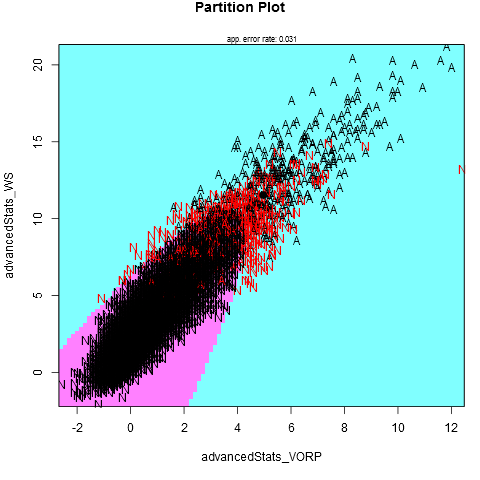

In [4]:
# Plot QDA decision boundary
%R library(klaR)
%R -i playerAggDfAllNbaAllStar partimat(accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, data = playerAggDfAllNbaAllStar, method = 'qda', col.mean = 1)

Okay, cool! As we saw when we were doing our manual decision boundary, it's kind of hard to tell how accurate these decision boundary are on graphs because of the skew in number of samples in each class. It looks like this boundary is doing really poorly for non all-NBA players, but I want to see the confusion matrix to make sure.

In [6]:
%R library(MASS)
%R allNbaQda = qda(accolades_all_nba ~ advancedStats_VORP + advancedStats_WS, data = playerAggDfAllNbaAllStar)

<ListVector - Python:0x000000000CE13A08 / R:0x0000000006262E80>
[Float..., IntVe..., Matrix, ..., Vector, Formula, ListV...]
  prior: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x000000000CE13348 / R:0x000000000EB3E3F0>
[0.037973, 0.962027]
  counts: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x000000000CE10F48 / R:0x000000000ED259E0>
[     502,    12718]
  means: <class 'rpy2.robjects.vectors.Matrix'>
  <Matrix - Python:0x000000000CE10D88 / R:0x000000000E468BA0>
[4.956375, 0.647460, 11.537052, 3.005858]
  ...
  prior: <class 'rpy2.robjects.vectors.Vector'>
  <Vector - Python:0x000000000CE10F08 / R:0x000000000E7B6130>
[RNULLType, Vector, Vector]
  counts: <class 'rpy2.robjects.Formula'>
  <Formula - Python:0x000000000CE10EC8 / R:0x000000000F10D670>
<ListVector - Python:0x000000000CE13A08 / R:0x0000000006262E80>
[Float..., IntVe..., Matrix, ..., Vector, Formula, ListV...]

In [7]:
# Predict using the existing data and model that we have
%R allNbaQdaPrediction = predict(allNbaQda)

# Generate confusion matrix and set -o flag to send results back to python
%R -o allNbaQdaConfMatrix allNbaQdaConfMatrix = as.data.frame(table(playerAggDfAllNbaAllStar[, c('accolades_all_nba')], allNbaQdaPrediction$class))

,Var1,Var2,Freq
1,All-NBA,All-NBA,367
2,Not All-NBA,All-NBA,278
3,All-NBA,Not All-NBA,135
4,Not All-NBA,Not All-NBA,12440


In [9]:
# Label dataframe indexes and columns correctly
allNbaQdaConfMatrix.index = ['All-NBA - Successfully Classified', 'Not All-NBA - Wrongly Classified', 'All-NBA - Wrongly Classified', 'Not All-NBA - Successfully Classified']
allNbaQdaConfMatrix.columns = ['True Value', 'Predicted Value', 'Freq']
allNbaQdaConfMatrix

,True Value,Predicted Value,Freq
All-NBA - Successfully Classified,All-NBA,All-NBA,367
Not All-NBA - Wrongly Classified,Not All-NBA,All-NBA,278
All-NBA - Wrongly Classified,All-NBA,Not All-NBA,135
Not All-NBA - Successfully Classified,Not All-NBA,Not All-NBA,12440


In [10]:
print 'All-NBA was classified correctly {} / {} ({})'.format(
    allNbaQdaConfMatrix.get_value('All-NBA - Successfully Classified', 'Freq'),
    allNbaQdaConfMatrix.get_value('All-NBA - Successfully Classified', 'Freq') + allNbaQdaConfMatrix.get_value('All-NBA - Wrongly Classified', 'Freq'),
    float(allNbaQdaConfMatrix.get_value('All-NBA - Successfully Classified', 'Freq')) / float(allNbaQdaConfMatrix.get_value('All-NBA - Successfully Classified', 'Freq') + allNbaQdaConfMatrix.get_value('All-NBA - Wrongly Classified', 'Freq'))*100
)

print 'Not All-NBA was classified correctly {} / {} ({})'.format(
    allNbaQdaConfMatrix.get_value('Not All-NBA - Successfully Classified', 'Freq'),
    allNbaQdaConfMatrix.get_value('Not All-NBA - Successfully Classified', 'Freq') + allNbaQdaConfMatrix.get_value('Not All-NBA - Wrongly Classified', 'Freq'),
    float(allNbaQdaConfMatrix.get_value('Not All-NBA - Successfully Classified', 'Freq')) / float(allNbaQdaConfMatrix.get_value('Not All-NBA - Successfully Classified', 'Freq') + allNbaQdaConfMatrix.get_value('Not All-NBA - Wrongly Classified', 'Freq'))*100
)

All-NBA was classified correctly 367 / 502 (73.1075697211)
Not All-NBA was classified correctly 12440 / 12718 (97.8141217173)


73% / 98%... Definitely better than LDA, but unfortunately not quite our manually picked boundary either. So with my current knowledge, I'm kind of at a loss for what we can do to improve the model.

The great thing at this point is that I'm able to actually apply these models literally within a few lines of code. I can get a prediction and I can also visualize the inner workings of the model, but how can I improve the model? I'm not quite sure if LDA or QDA actually have any parameters that we can tweak to customize the model. I know, for example, other models like the support vector machine have somewhat of a 'forgivingness' parameters that allows you to choose (I think...) how many support vectors you want. Something like logistic regression also allows you to choose where what cutoff in the response sigmoid you want so that you optimize your classification accuracy on both ends.

Speaking of logistic regression... why don't we use that to take a crack at our classification problem! Stay tuned!